In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import itertools
import time

from fredapi import Fred

In [2]:
# FRED API key required
key = open('data/fred_api.txt').readlines()[0]
fred = Fred(api_key = key)

# dict of column names to series IDs, dictated by FRED
series_ids = {
    'earnings':'CES0500000003', # average hourly earnings, total private
    'gdp':'GDP', # nominal gdp
    'stocks':'WILLLRGCAPPR', # Wilshire US Large-Cap Price Index, proxy for SP500
    'unemployment':'UNRATE', #U3 unemployment
    'govt_expenditures_total':'W068RCQ027SBEA', # total govt expenditures
    'govt_expenditures_fed':'FGEXPND', # federal govt expenditures
    'public_debt':'GFDEBTN', # total public debt
    'fed_funds':'FEDFUNDS', # effective fed funds rate
    'eitc':'ENINCCTA', # earned income tax credit
    'gini':'SIPOVGINIUSA', # GINI coefficient, measure of income inequality
}

# some series only have annual frequency
annual_series = ['eitc', 'gini'] 

# dataframe to consolidate results
df = pd.DataFrame()

# loop through series, query FRED and add to df
for series in series_ids:
    
    freq = 'q' if series not in annual_series else 'a'
    
    data = pd.DataFrame(
        fred.get_series(
            series_id = series_ids[series],
            observation_start = '2000-12-31',
            observation_end = None,
            frequency = freq,
            units = 'lin'
        ),
        columns = [series]
    )
    
    df = pd.concat([df, data], axis = 1)

df

,earnings,gdp,stocks,unemployment,govt_expenditures_total,govt_expenditures_fed,public_debt,fed_funds,eitc,gini
2000-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32296341.0,40.1
2000-10-01,NaN,10435.744,3090.50,3.9,3210.083,1938.796,5662216.0,6.47,NaN,NaN
2001-01-01,NaN,10470.231,2840.93,4.2,3280.819,1982.626,5773740.0,5.59,33375971.0,40.6
2001-04-01,NaN,10599.000,2739.95,4.4,3358.217,2003.581,5726815.0,4.33,NaN,NaN
2001-07-01,NaN,10598.020,2557.58,4.8,3377.367,2037.703,5807464.0,3.50,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-10-01,32.79,26408.405,9033.40,3.6,9175.833,6175.709,31419689.0,3.65,NaN,NaN
2023-01-01,33.11,26813.601,9380.93,3.5,9326.383,6324.782,31458438.0,4.52,NaN,NaN
2023-04-01,33.46,27063.012,9847.26,3.6,9422.404,6346.294,32332274.0,4.99,NaN,NaN
2023-07-01,33.83,27623.543,10456.58,3.7,9985.533,6392.615,NaN,5.26,NaN,NaN


In [3]:
# create growth rate columns
# for annual-only series, first linearly interpolate
growth_cols = {}

for col in df.columns:
    if col not in annual_series:
        growth_cols[col + '_growth'] = df[col].pct_change()
    else:
        df[col] = df[col].interpolate(method = 'linear', axis = 0)
        growth_cols[col + '_growth'] = df[col].pct_change()

# create differenced columns
diff_cols = {}

for col in df.columns:
    diff_cols[col + '_diff'] = df[col].diff()

# concatenate new columns with original df
df = pd.concat([df, pd.DataFrame(growth_cols), pd.DataFrame(diff_cols)], axis = 1)

# create lead / lag columns columns
# I use +/- 4 to create windows a year before and after
# I also exclude 'earnings' since that is our target variable
lead_lag_cols = {}
earnings_cols = [x for x in df.columns if 'earnings' in x]

for col in df.drop(earnings_cols, axis = 1).columns:
    for k in range(1,5):
        lead_lag_cols[f'{col}_lag_{k}'] = df[col].shift(k)
        lead_lag_cols[f'{col}_lead_{k}'] = df[col].shift(-k)

# concatenate once again
df = pd.concat([df, pd.DataFrame(lead_lag_cols)], axis = 1)

df.shape

(94, 246)

In [4]:
df = df.dropna(subset = earnings_cols)

for col in series_ids:
    print(f'{col}: {len( df[pd.isnull(df[col])] )}')
    
print(f'\nDataframe Dimensions: {df.shape}')

earnings: 0
gdp: 0
stocks: 0
unemployment: 0
govt_expenditures_total: 0
govt_expenditures_fed: 0
public_debt: 1
fed_funds: 0
eitc: 0
gini: 0

Dataframe Dimensions: (69, 246)


In [5]:
df = df.dropna()

# we have three subsets, based on how the y and X variables are transformed
growth_cols = [x for x in df.columns if 'growth' in x]
diff_cols = [x for x in df.columns if 'diff' in x]
level_cols = [x for x in df.columns if 'growth' not in x and 'diff' not in x]

variable_groups = [growth_cols, diff_cols, level_cols]
variable_group_names = ['growth', 'diff', 'level']
number_features = 3

# loop through each subset and check each combination of variables
# If a combo has more than one type of the sample variable, remove that combo
# For example, if a combo has gdp_lag and gdp_lead, remove it
for group, group_name in zip(variable_groups, variable_group_names):
    subset = df[group]
    variables = [x for x in subset.columns if 'earnings' not in x]
    all_combos = itertools.combinations(variables, number_features)
    globals()['var_combos_' + group_name] = []

    start = time.perf_counter()
    for i, combo in enumerate(all_combos):

        exclude = False
        for series in series_ids.keys():
            if ' '.join(combo).count(series) > 1:
                exclude = True
        if exclude == False:
            globals()['var_combos_' + group_name].append(combo)

    print(f'Final no. of combinations for {group_name}: {len(globals()["var_combos_" + group_name]):,}')

Final no. of combinations for growth: 61,236
Final no. of combinations for diff: 61,236
Final no. of combinations for level: 61,236


In [6]:
# Group up each type of transformed variable subset
# All growth variables, all diff variables, all levels variables
variable_group_combos = [var_combos_growth, var_combos_diff, var_combos_level]

# Initial variables - store all fits in a dict
model_fits = {}
counter = 0

# Loop through each type of transformed variable subset
# E.g. use only diff variables to predict earnings_diff,
# growth for earnings_growth, levels for earnings_levels
start = time.perf_counter()
for group, combos in zip(variable_groups, variable_group_combos):
    subset = df[group]
    y = subset.filter(like = 'earnings')
    
    for combo in combos:
        X = subset[list(combo)]
        X = sm.add_constant(X)
        model_fits[counter] = sm.OLS(y,X).fit()

        counter += 1
        if counter % ((10**5) / 2) == 0:
            now = time.perf_counter()
            print(
                f'Done with {counter:,} models\n',
                f'Time so far: {(now-start)/60:.2f} minutes'
            )

now = time.perf_counter()
print(
    f'Process fully complete with {counter:,} models\n',
    f'Time to complete: {(now-start)/60:.2f} minutes'
)

Done with 50,000 models
 Time so far: 0.84 minutes
Done with 100,000 models
 Time so far: 1.69 minutes
Done with 150,000 models
 Time so far: 2.55 minutes
Process fully complete with 183,708 models
 Time to complete: 3.13 minutes


In [70]:
%%capture --no-stdout

starting_length = len(model_fits)
start = time.perf_counter()

def print_progress():
    print(
        f'Models removed due to significance: {starting_length - len(model_fits_clean):,}\n'
        f"Remaining levels models: {len([x.params.index.tolist() for x in model_fits_clean.values() if 'growth' not in ' '.join(x.params.index) and 'diff' not in ' '.join(x.params.index)])}\n"
        f"Remaining growth models: {len([x.params.index.tolist() for x in model_fits_clean.values() if 'growth' in ' '.join(x.params.index)])}\n"
        f"Remaining diff models: {len([x.params.index.tolist() for x in model_fits_clean.values() if 'diff' in ' '.join(x.params.index)])}\n"
    )

# include only models that overall appear significant based on F-test
model_fits_clean = {key: value for key, value in model_fits.items() if value.f_pvalue <= 0.1}
print_progress()

# include only models with stationary residuals
starting_length = len(model_fits_clean)
model_fits_clean = {
    key: value for key, value in model_fits_clean.items() 
    if sm.tsa.stattools.adfuller(value.resid)[1] >= 0.05
}
print_progress()

# include only models with max VIF lower than 10
starting_length = len(model_fits_clean)
model_fits_clean = {
    key: value for key, value in model_fits_clean.items() 
    if max([variance_inflation_factor(value.model.exog, i) for i in range(number_features+1)]) <= 20
}
print_progress()

# include only models with ~normal residuals
starting_length = len(model_fits_clean)
model_fits_clean = {
    key: value for key, value in model_fits_clean.items() 
    if sps.shapiro(value.resid)[1] >= 0.05
}
print_progress()

now = time.perf_counter()
print(
    f'Remaining number of models: {len(model_fits_clean):,}\n'
    f'Time to complete: {(now-start)/60:.2f} minutes'
)

Models removed due to significance: 54,969
Remaining levels models: 61236
Remaining growth models: 29713
Remaining diff models: 37790

Models removed due to significance: 49,498
Remaining levels models: 29775
Remaining growth models: 20027
Remaining diff models: 29439

Models removed due to significance: 28,834
Remaining levels models: 960
Remaining growth models: 20015
Remaining diff models: 29432

Models removed due to significance: 49,865
Remaining levels models: 427
Remaining growth models: 33
Remaining diff models: 82

Remaining number of models: 542
Time to complete: 5.43 minutes


In [71]:
# Use dict comprehension to pull out key values from model fits
model_data = {
    key: [
        value.params.index.tolist(),
        value.rsquared_adj,
        value.mse_resid,
        value.aic
    ] for key, value in model_fits_clean.items()
}

# Convert dict to dataframe, assign columns
model_data = pd.DataFrame.from_dict(
    model_data, orient = 'index',
    columns = [
        'predictors',
        'r2',
        'mse',
        'aic'
    ]
)

model_data.head()

,predictors,r2,mse,aic
4859,"[const, unemployment_growth, gdp_growth_lag_1,...",0.835174,0.000004,-605.655073
6657,"[const, govt_expenditures_total_growth, govt_e...",0.666293,0.000009,-560.511163
6716,"[const, govt_expenditures_total_growth, public...",0.577642,0.000011,-545.433388
8738,"[const, govt_expenditures_fed_growth, public_d...",0.661954,0.000009,-559.684321
11022,"[const, public_debt_growth, gdp_growth_lag_2, ...",0.490897,0.000013,-533.478361


In [72]:
# The orientation of r2 (higher is better) is opposite of mse and aic (lower is better)
# So I create an inverse r2 column and use that in the ranking
model_data['r2_inverse'] = 1 - model_data.r2
model_data['rank'] = model_data.loc[:,['mse','aic','r2_inverse']].rank(method = 'first').mean(axis = 1)
model_data.drop('r2_inverse', axis = 1, inplace = True)
model_data.sort_values('rank', inplace = True)

# Let's see the top 10 best and worst
display(
    model_data.head(10),
    model_data.tail(10)
)

,predictors,r2,mse,aic,rank
134122,"[const, public_debt, stocks_lag_4, govt_expend...",0.995859,0.039696,-21.002340,77.666667
132153,"[const, govt_expenditures_fed, stocks_lag_4, p...",0.994780,0.050041,-6.180704,78.666667
163869,"[const, stocks_lag_4, govt_expenditures_fed_la...",0.994654,0.051252,-4.650548,79.666667
134120,"[const, public_debt, stocks_lag_4, govt_expend...",0.994634,0.051444,-4.411643,80.666667
164089,"[const, stocks_lag_4, public_debt_lead_1, fed_...",0.994593,0.051836,-3.925670,81.666667
134024,"[const, public_debt, stocks_lag_3, govt_expend...",0.994583,0.051930,-3.809630,82.666667
134118,"[const, public_debt, stocks_lag_4, govt_expend...",0.994330,0.054359,-0.883966,83.666667
134130,"[const, public_debt, stocks_lag_4, fed_funds_l...",0.994098,0.056577,1.676127,84.666667
134128,"[const, public_debt, stocks_lag_4, fed_funds_l...",0.994065,0.056891,2.030551,85.666667
158591,"[const, stocks_lag_2, govt_expenditures_fed_le...",0.994031,0.057217,2.395313,86.666667


,predictors,r2,mse,aic,rank
155845,"[const, stocks_lag_1, govt_expenditures_fed_le...",0.958345,0.399313,126.741007,494.666667
125009,"[const, stocks, fed_funds, govt_expenditures_f...",0.957908,0.403509,127.410090,495.666667
163876,"[const, stocks_lag_4, govt_expenditures_fed_la...",0.957326,0.409087,128.288767,496.666667
158469,"[const, stocks_lag_2, govt_expenditures_fed_le...",0.956993,0.412276,128.785647,497.666667
131969,"[const, govt_expenditures_fed, stocks_lag_2, f...",0.955868,0.423057,130.437847,498.666667
135924,"[const, fed_funds, stocks_lag_3, govt_expendit...",0.955159,0.429861,131.458867,499.666667
126410,"[const, stocks, govt_expenditures_fed_lead_2, ...",0.951805,0.462014,136.075354,500.666667
155847,"[const, stocks_lag_1, govt_expenditures_fed_le...",0.951650,0.463493,136.279926,501.666667
157126,"[const, stocks_lead_1, govt_expenditures_fed_l...",0.951048,0.469264,137.071892,502.666667
126540,"[const, stocks, govt_expenditures_fed_lead_4, ...",0.950987,0.469854,137.152326,503.666667


                            OLS Regression Results                            
Dep. Variable:               earnings   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     5051.
Date:                Wed, 15 Nov 2023   Prob (F-statistic):           4.71e-72
Time:                        01:09:24   Log-Likelihood:                 14.501
No. Observations:                  64   AIC:                            -21.00
Df Residuals:                      60   BIC:                            -12.37
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

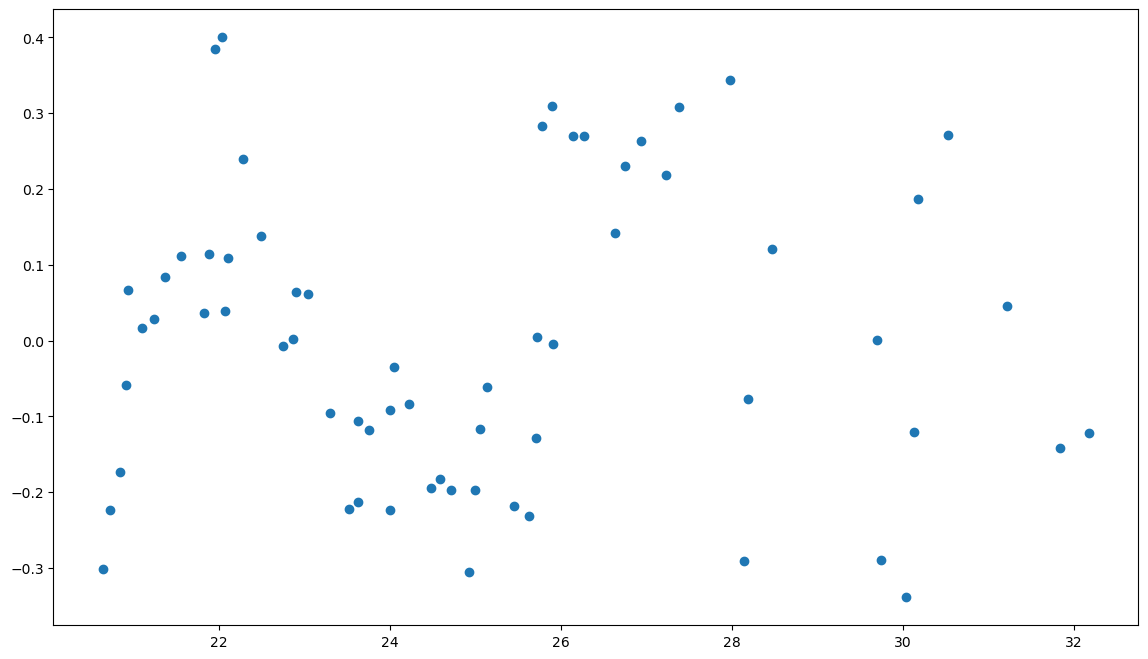

In [73]:
best_model = model_fits_clean[model_data.index[0]]

print(best_model.summary())

fig, ax = plt.subplots(figsize=(14, 8)) 
ax.scatter(best_model.fittedvalues, best_model.resid)
plt.show()

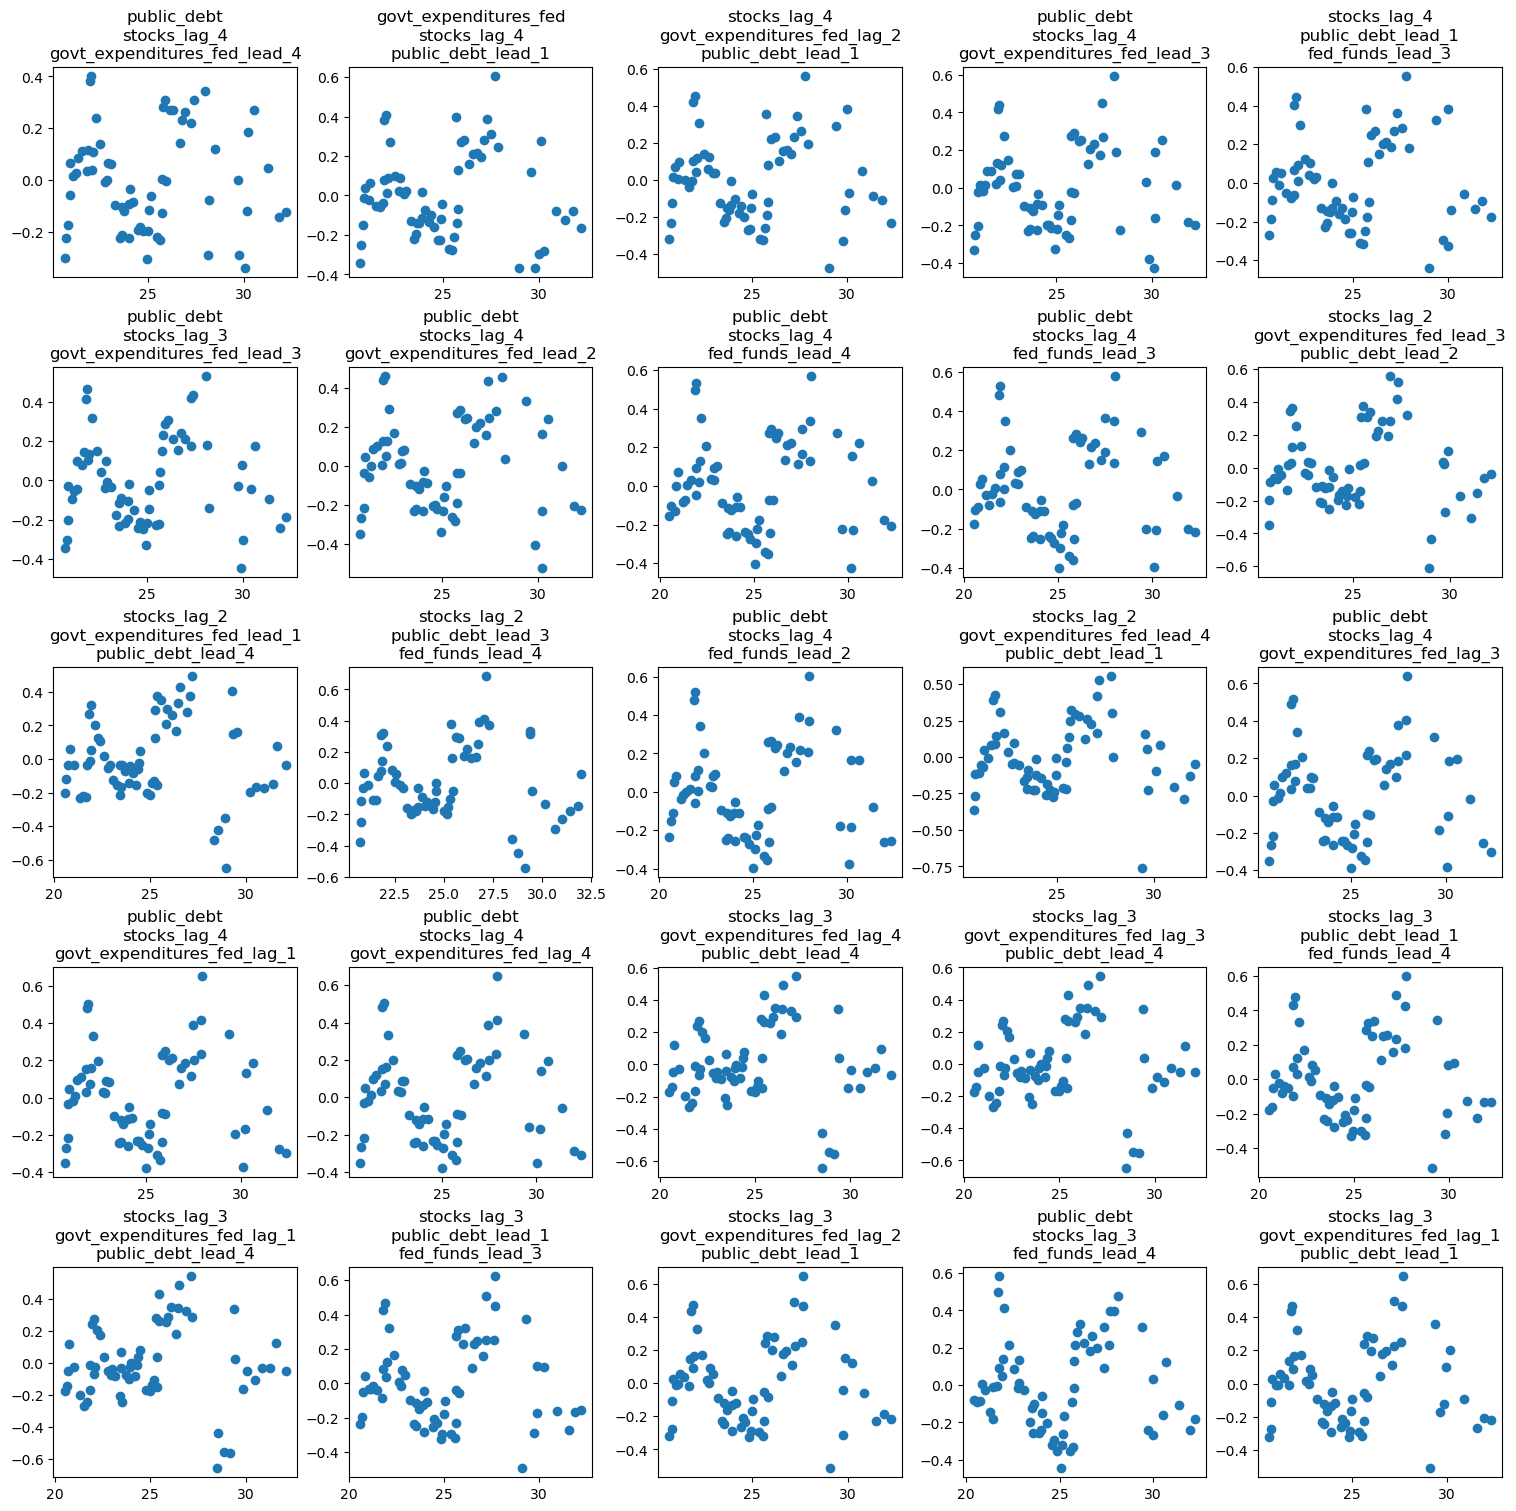

In [74]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15), layout = 'constrained') 
for i, ax in zip(range(25), axes.ravel()):
    model = model_fits_clean[model_data.index[i]]
    ax.scatter(model.fittedvalues, model.resid)
    ax.set_title("\n".join(model.params.index.tolist()[1:]))
plt.show()

In [75]:
model_data['transformation'] = (
    model_data.predictors.apply(lambda x: ' '.join(x))
    .apply(lambda x: 'growth' if 'growth' in x else 'diff' if 'diff' in x else 'levels')
)

model_data.transformation.value_counts()

transformation
levels    427
diff       82
growth     33
Name: count, dtype: int64